In [1]:
# creating paths to src and data folders in the repo
import sys
import pathlib
src_path = pathlib.Path().absolute().parent.parent / "src"
data_path = pathlib.Path().absolute().parent.parent / "data"

# train test split paths
train_path = data_path / 'binary_tts/train'
test_path = data_path / 'binary_tts/test'
val_path = data_path / 'binary_tts/val'

# add src path to sys.path so it is searched in import statements
sys.path.append(str(src_path))

# basic imports for data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# silence max image size warning
from PIL import Image
Image.MAX_IMAGE_PIXELS = 1000000000 

# import modeling packages
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# modeling metrics
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix

changes to data generators:
    
    interpolation 'nearest' -> 'bicubic'
    
    target_size 150x150 -> 200x200
    

In [2]:
train_generator = ImageDataGenerator().flow_from_directory(str(train_path),
                                                           target_size=(300, 300),
                                                           batch_size=20,
                                                           class_mode='binary',
                                                           interpolation='bicubic')
test_generator = ImageDataGenerator().flow_from_directory(str(test_path),
                                                          target_size=(300, 300),
                                                          batch_size=20,
                                                          class_mode='binary',
                                                          interpolation='bicubic',
                                                          shuffle=False)
val_generator = ImageDataGenerator().flow_from_directory(str(val_path),
                                                         target_size=(300, 300),
                                                         batch_size=20,
                                                         class_mode='binary',
                                                         interpolation='bicubic',
                                                         shuffle=False)

Found 6000 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


changes to model architecture:
    
    input_shape 150x150 -> 200x200
    
    num conv2d layers 2 -> 1
    
    output num_nodes 2 -> 1
    
    output_activation 'softmax -> sigmoid'
    
    MaxPooling pool_size 2x2 -> 5x5

In [3]:
model = models.Sequential()
model.add(layers.Conv2D(35, (3, 3), activation='relu', input_shape=(300, 300, 3)))
model.add(layers.MaxPooling2D((5, 5)))
model.add(layers.Conv2D(20, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((3, 3)))
model.add(layers.Flatten())
model.add(layers.Dense(40, activation='relu'))
model.add(layers.Dropout(.2))
model.add(layers.Dense(40, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [4]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 298, 298, 35)      980       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 59, 59, 35)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 57, 57, 20)        6320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 19, 19, 20)        0         
_________________________________________________________________
flatten (Flatten)            (None, 7220)              0         
_________________________________________________________________
dense (Dense)                (None, 40)                288840    
_________________________________________________________________
dropout (Dropout)            (None, 40)                0

changes to fit:
    
    epochs 10 -> 5
    
    steps_per_epoch 200 -> 300

In [5]:
model.fit(
        train_generator,
        steps_per_epoch=300,
        epochs=6,
        validation_data=test_generator,
        validation_steps=10)

Epoch 1/6
298/300 [============================>.] - ETA: 7s - loss: 1.4892 - accuracy: 0.5683 

/opt/anaconda3/envs/new_capstone-env/lib/python3.6/site-packages/PIL/Image.py:952: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


300/300 [==============================] - 1091s 4s/step - loss: 1.4837 - accuracy: 0.5677 - val_loss: 0.6761 - val_accuracy: 0.5400
Epoch 2/6
300/300 [==============================] - 1088s 4s/step - loss: 0.6641 - accuracy: 0.6147 - val_loss: 0.6432 - val_accuracy: 0.5550
Epoch 3/6
300/300 [==============================] - 1096s 4s/step - loss: 0.6390 - accuracy: 0.6447 - val_loss: 0.6196 - val_accuracy: 0.5650
Epoch 4/6
300/300 [==============================] - 1093s 4s/step - loss: 0.6089 - accuracy: 0.6803 - val_loss: 0.6687 - val_accuracy: 0.5100
Epoch 5/6
300/300 [==============================] - 1089s 4s/step - loss: 0.5754 - accuracy: 0.7048 - val_loss: 0.6668 - val_accuracy: 0.5150
Epoch 6/6
300/300 [==============================] - 1090s 4s/step - loss: 0.5603 - accuracy: 0.7178 - val_loss: 0.7610 - val_accuracy: 0.4800


Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


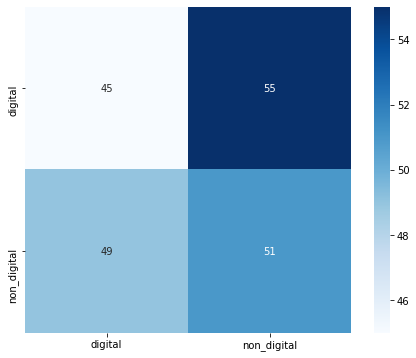

In [6]:
conf_mat = confusion_matrix(test_generator.classes, model.predict_classes(test_generator))

class_names = list(test_generator.class_indices.keys())

fig, ax = plt.subplots(figsize=(8,6))
model_10_path = pathlib.Path().absolute().parent.parent / 'reports/figures/mod_10_heatmap.png'
ax.set_ylim([0,1])
sns.heatmap(conf_mat, xticklabels=class_names, yticklabels=class_names, ax=ax, square=True, annot=True, cmap='Blues')
plt.savefig(model_10_path)

In [7]:
accuracies = []
for i in range(0, 2):
    acc = conf_mat[i][i] / sum(conf_mat[i])
    accuracies.append(acc)
accuracies

[0.45, 0.51]